In [22]:
# 1. Importing Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# 2. Load and inspect data

df = pd.read_csv(r'C:\Users\Welcome\Desktop\Python Coding Projects\House rent prediction\data\House_Rent_Dataset.csv')

print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB
None
               BHK          Rent         Size     Bathroom
count  4746.000000  4.746000e+03  4746.000000  4746.000000
mean      2.083860  3.499345e+04   967.490729     1.965866
s

In [3]:
# replacing 'Ground' with 0
df['Floor'] = df['Floor'].str.replace('Ground','0',regex=False)

# Extracting current floor and total number of floors in the building
df[['current_floor','total_floors']] = df['Floor'].str.extract(r'(\d+)\s+out of\s+(\d+)').astype(float)


In [4]:
df = df.drop(columns=['Floor','Area Locality'])

numerical_features = ['BHK','Size','current_floor','total_floors','Bathroom']
categorical_features = ['Area Type','City','Furnishing Status','Tenant Preferred','Point of Contact']
target = ['Rent']


df.head()


,Posted On,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,current_floor,total_floors
0,2022-05-18,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0.0,2.0
1,2022-05-13,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1.0,3.0
2,2022-05-16,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1.0,3.0
3,2022-07-04,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1.0,2.0
4,2022-05-09,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1.0,2.0


In [5]:
# 3. Handling missing values

for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        if df[col].skew() > 1:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)

In [6]:
# 4. Outlier Treatment

num_cols = df.select_dtypes(include=['int64','float64']).columns

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df[col] = df[col].clip(lower=lower_bound,upper=upper_bound)

In [7]:
# 5. Feature Engineering

df['BHK_per_1000sqft'] = df['BHK']*1000.0/df['Size'] # Helps normalize BHKs by space and detect cramped apartments
df['Floor_ratio'] = df['current_floor']*1.0/df['total_floors'] # Gives a normalised sense of where the apartment is in the building
df['Room_density'] = df['Size'] / (df['BHK']+df['Bathroom']) # Can help highlight compact vs spacious apartments
df['is_top_floor'] = (df['current_floor'] == df['total_floors']).astype(int) # May affect rent positively or negatively based on the city

df

,Posted On,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,current_floor,total_floors,BHK_per_1000sqft,Floor_ratio,Room_density,is_top_floor
0,2022-05-18,2.0,10000.0,1100.0,Super Area,Kolkata,Unfurnished,Bachelors/Family,2.0,Contact Owner,0.0,2.0,1.818182,0.000000,275.000000,0
1,2022-05-13,2.0,20000.0,800.0,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1.0,Contact Owner,1.0,3.0,2.500000,0.333333,266.666667,0
2,2022-05-16,2.0,17000.0,1000.0,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1.0,Contact Owner,1.0,3.0,2.000000,0.333333,333.333333,0
3,2022-07-04,2.0,10000.0,800.0,Super Area,Kolkata,Unfurnished,Bachelors/Family,1.0,Contact Owner,1.0,2.0,2.500000,0.500000,266.666667,0
4,2022-05-09,2.0,7500.0,850.0,Carpet Area,Kolkata,Unfurnished,Bachelors,1.0,Contact Owner,1.0,2.0,2.352941,0.500000,283.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2.0,15000.0,1000.0,Carpet Area,Hyderabad,Semi-Furnished,Bachelors/Family,2.0,Contact Owner,3.0,5.0,2.000000,0.600000,250.000000,0
4742,2022-05-15,3.0,29000.0,2000.0,Super Area,Hyderabad,Semi-Furnished,Bachelors/Family,3.0,Contact Owner,1.0,4.0,1.500000,0.250000,333.333333,0
4743,2022-07-10,3.0,35000.0,1750.0,Carpet Area,Hyderabad,Semi-Furnished,Bachelors/Family,3.0,Contact Agent,3.0,5.0,1.714286,0.600000,291.666667,0
4744,2022-07-06,3.0,45000.0,1500.0,Carpet Area,Hyderabad,Semi-Furnished,Family,2.0,Contact Agent,6.0,12.0,2.000000,0.500000,300.000000,0


In [10]:
# 6. Encoding Categorical Variables

categorical_features = ['Area Type','City','Furnishing Status','Tenant Preferred','Point of Contact']

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
df

,Posted On,BHK,Rent,Size,Bathroom,current_floor,total_floors,BHK_per_1000sqft,Floor_ratio,Room_density,...,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,2022-05-18,2.0,10000.0,1100.0,2.0,0.0,2.0,1.818182,0.000000,275.000000,...,0,0,1,0,0,1,1,0,0,1
1,2022-05-13,2.0,20000.0,800.0,1.0,1.0,3.0,2.500000,0.333333,266.666667,...,0,0,1,0,1,0,1,0,0,1
2,2022-05-16,2.0,17000.0,1000.0,1.0,1.0,3.0,2.000000,0.333333,333.333333,...,0,0,1,0,1,0,1,0,0,1
3,2022-07-04,2.0,10000.0,800.0,1.0,1.0,2.0,2.500000,0.500000,266.666667,...,0,0,1,0,0,1,1,0,0,1
4,2022-05-09,2.0,7500.0,850.0,1.0,1.0,2.0,2.352941,0.500000,283.333333,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2.0,15000.0,1000.0,2.0,3.0,5.0,2.000000,0.600000,250.000000,...,0,1,0,0,1,0,1,0,0,1
4742,2022-05-15,3.0,29000.0,2000.0,3.0,1.0,4.0,1.500000,0.250000,333.333333,...,0,1,0,0,1,0,1,0,0,1
4743,2022-07-10,3.0,35000.0,1750.0,3.0,3.0,5.0,1.714286,0.600000,291.666667,...,0,1,0,0,1,0,1,0,0,0
4744,2022-07-06,3.0,45000.0,1500.0,2.0,6.0,12.0,2.000000,0.500000,300.000000,...,0,1,0,0,1,0,0,1,0,0


In [11]:
df.columns

Index(['Posted On', 'BHK', 'Rent', 'Size', 'Bathroom', 'current_floor',
       'total_floors', 'BHK_per_1000sqft', 'Floor_ratio', 'Room_density',
       'is_top_floor', 'Area Type_Carpet Area', 'Area Type_Super Area',
       'City_Chennai', 'City_Delhi', 'City_Hyderabad', 'City_Kolkata',
       'City_Mumbai', 'Furnishing Status_Semi-Furnished',
       'Furnishing Status_Unfurnished', 'Tenant Preferred_Bachelors/Family',
       'Tenant Preferred_Family', 'Point of Contact_Contact Builder',
       'Point of Contact_Contact Owner'],
      dtype='object')

In [12]:
# 7. Scaling Numerical Features

features_to_scale = ['BHK', 'Size', 'Bathroom', 'current_floor',
                      'total_floors', 'BHK_per_1000sqft', 'Floor_ratio', 'Room_density']

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [16]:
# 8. Train-Test Split

X = df.drop(columns=['Rent','Posted On'])
y = df['Rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
# 9. Linear Regression Model

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [20]:
# 10. Evaluation

print('R2 Score:', r2_score(y_test, y_pred))
print('RMSE :', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.7995745719872916
RMSE : 8814.305792126708


In [23]:
# 11. Cross-Validation

cv_scores = cross_val_score(lr, X, y, scoring = 'neg_root_mean_squared_error', cv = 5)
print('Cross-Validation RMSE:', -np.mean(cv_scores))

Cross-Validation RMSE: 9687.06758508149


In [27]:
# 12. StatsModels Summary Report

X_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rent   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     608.1
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:29:37   Log-Likelihood:                -40102.
No. Observations:                3796   AIC:                         8.025e+04
Df Residuals:                    3773   BIC:                         8.039e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [30]:
# 13. VIF Check

X_vif = pd.DataFrame(X_train, columns = X.columns)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))

                              feature        VIF
1                                Size  19.531658
10               Area Type_Super Area  14.399669
3                       current_floor  11.962968
9               Area Type_Carpet Area  10.309301
4                        total_floors   8.627395
7                        Room_density   7.644701
21     Point of Contact_Contact Owner   6.722599
2                            Bathroom   6.120093
18  Tenant Preferred_Bachelors/Family   6.033016
0                                 BHK   5.895006
6                         Floor_ratio   5.401689
16   Furnishing Status_Semi-Furnished   4.503545
17      Furnishing Status_Unfurnished   3.953274
15                        City_Mumbai   3.613546
8                        is_top_floor   2.250514
11                       City_Chennai   2.075816
13                     City_Hyderabad   2.062799
12                         City_Delhi   1.920858
14                       City_Kolkata   1.806178
19            Tenant

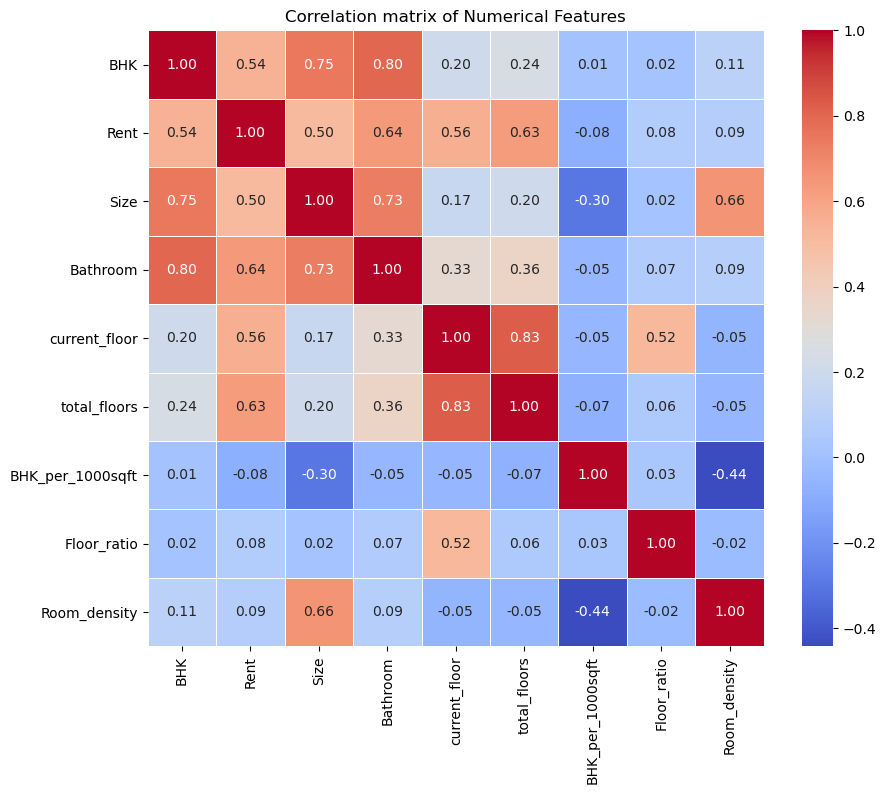

In [32]:
# 14. Corr Matrix

num_cols = df.select_dtypes(include=['int64','float64']).columns

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation matrix of Numerical Features')
plt.show()

--------------Lasso Regularisation----------------

In [33]:
# Importing libraries

from sklearn.linear_model import LassoCV

In [34]:
# Fitting LassoCV

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

LassoCV(cv=5, random_state=42)

In [35]:
# Checking coefficients

lasso_coef = pd.Series(lasso.coef_, index=X_train.columns)
print(lasso_coef)

BHK                                   2725.011875
Size                                  5519.953871
Bathroom                              2754.083515
current_floor                           88.998343
total_floors                          1822.607093
BHK_per_1000sqft                       599.501868
Floor_ratio                           -188.211481
Room_density                             0.000000
is_top_floor                          1157.602198
Area Type_Carpet Area                  680.445483
Area Type_Super Area                    -0.000000
City_Chennai                          -479.511202
City_Delhi                            3594.973167
City_Hyderabad                       -3021.563363
City_Kolkata                         -2462.440757
City_Mumbai                          19524.371412
Furnishing Status_Semi-Furnished     -3785.324687
Furnishing Status_Unfurnished        -4554.015653
Tenant Preferred_Bachelors/Family     -306.020337
Tenant Preferred_Family              -3107.983119


In [38]:
# Selecting important features

selected_features = lasso_coef[lasso_coef != 0].index.tolist()
print('Selected features by Lasso:', selected_features)

Selected features by Lasso: ['BHK', 'Size', 'Bathroom', 'current_floor', 'total_floors', 'BHK_per_1000sqft', 'Floor_ratio', 'is_top_floor', 'Area Type_Carpet Area', 'City_Chennai', 'City_Delhi', 'City_Hyderabad', 'City_Kolkata', 'City_Mumbai', 'Furnishing Status_Semi-Furnished', 'Furnishing Status_Unfurnished', 'Tenant Preferred_Bachelors/Family', 'Tenant Preferred_Family', 'Point of Contact_Contact Owner']


In [40]:
# Running Linear Regression with selected features

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

lr.fit(X_train_selected, y_train)
y_pred = lr.predict(X_test_selected)

In [41]:
# Checking performance


print('R2 Score:', r2_score(y_test, y_pred))
print('RMSE :', np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.7995900895711425
RMSE : 8813.964569513142


In [42]:
# StatsModels Summary Report

X_const = sm.add_constant(X_train_selected)
model = sm.OLS(y_train, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rent   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     704.6
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        04:01:56   Log-Likelihood:                -40103.
No. Observations:                3796   AIC:                         8.025e+04
Df Residuals:                    3776   BIC:                         8.037e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 